#### Andrew Taylor
#### atayl136
#### EN 705.601 Applied Machine Learning
## Homework 8

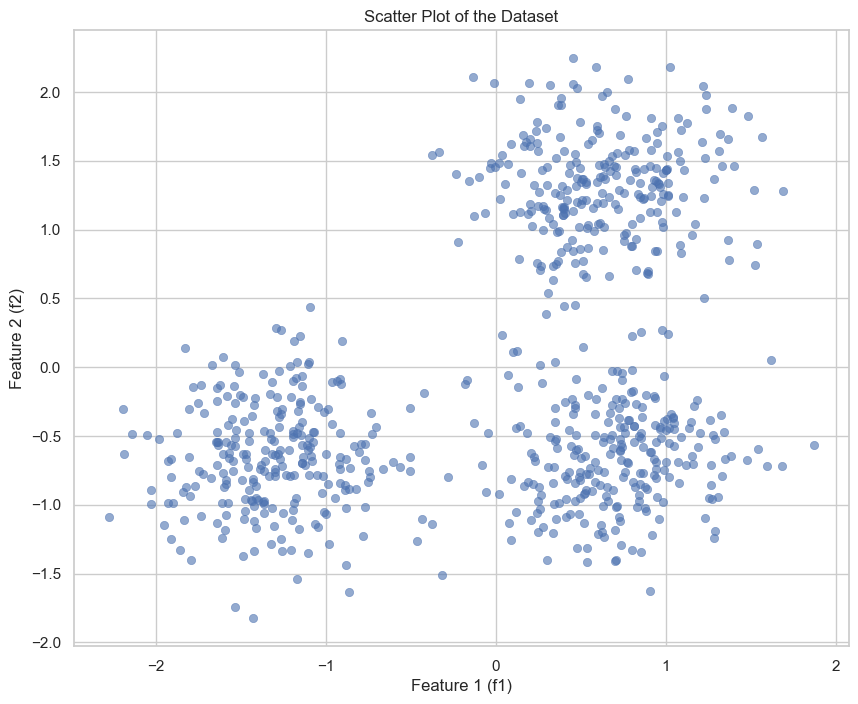

In [1]:
# Question 1: Number-of-Clusters via visual inspection, Elbow Method, and Silhouette Analysis

# Importing necessary libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Path to the dataset
dataset_path = 'clustering_synthetic_dataset.csv'

# Load the dataset into a pandas DataFrame
df = pd.read_csv(dataset_path)

# Set the style of the plots
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x="f1", y="f2", data=df, alpha=0.6, edgecolor=None)
plt.title("Scatter Plot of the Dataset")
plt.xlabel("Feature 1 (f1)")
plt.ylabel("Feature 2 (f2)")
plt.show()


##### Visually it looks like we are dealing with 3 Species. Let's confirm that via Elbow Method and Silhouette Analysis.

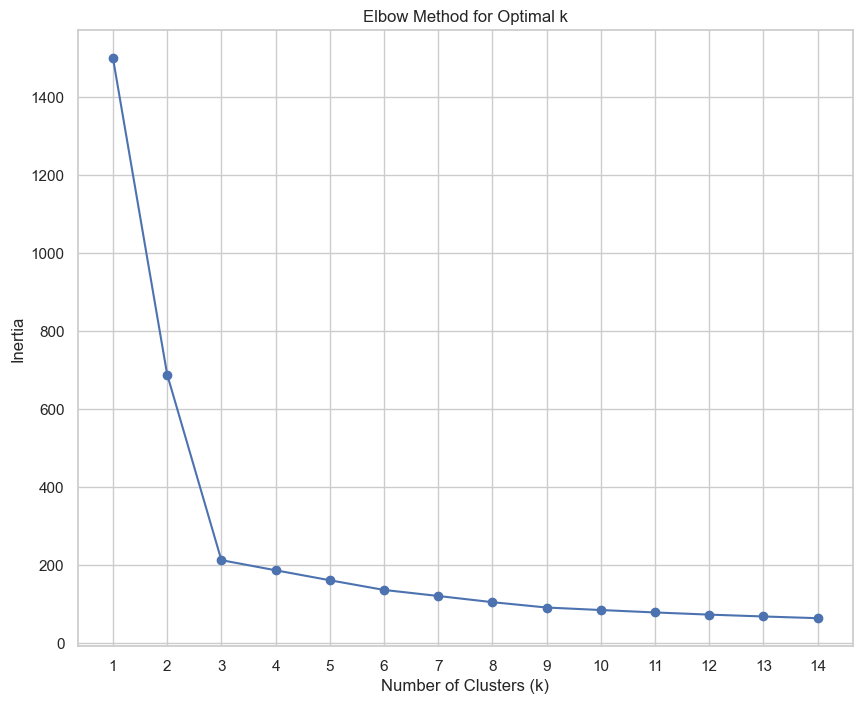

In [2]:
# Question 1: Elbow Method

from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# Initialize variables
inertia_values = []
k_values = range(1, 15)

# Perform k-means clustering for different values of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(10, 8))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


The Elbow Method graph shows the inertia values for different numbers of clusters (k). As we can see, the inertia decreases sharply up to k=3 and then starts to level off. This "elbow" point at k=3 suggests that 3 might be an appropriate number of clusters for this dataset.

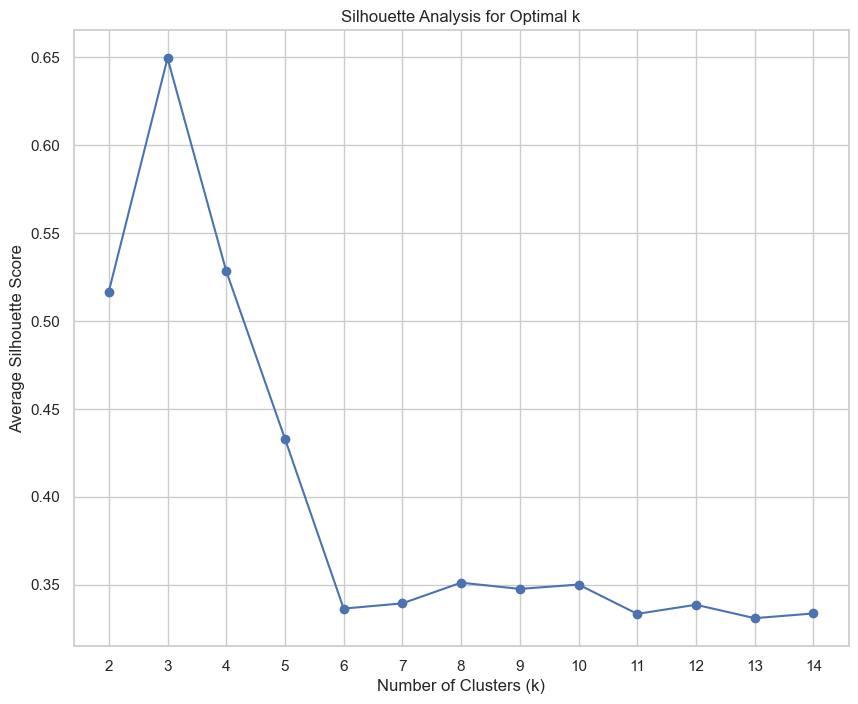

In [3]:
# Question 1: Silhouette Analysis

from sklearn.metrics import silhouette_score

# Initialize variables
silhouette_scores = []

# Perform k-means clustering for different values of k and calculate silhouette scores
for k in range(2, 15):  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Analysis graph
k_values_silhouette = range(2, 15)
plt.figure(figsize=(10, 8))
plt.plot(k_values_silhouette, silhouette_scores, marker='o')
plt.title('Silhouette Analysis for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_values_silhouette)
plt.grid(True)
plt.show()


We get k=3 looking at the highest average siloutte score as well. Let's move on.

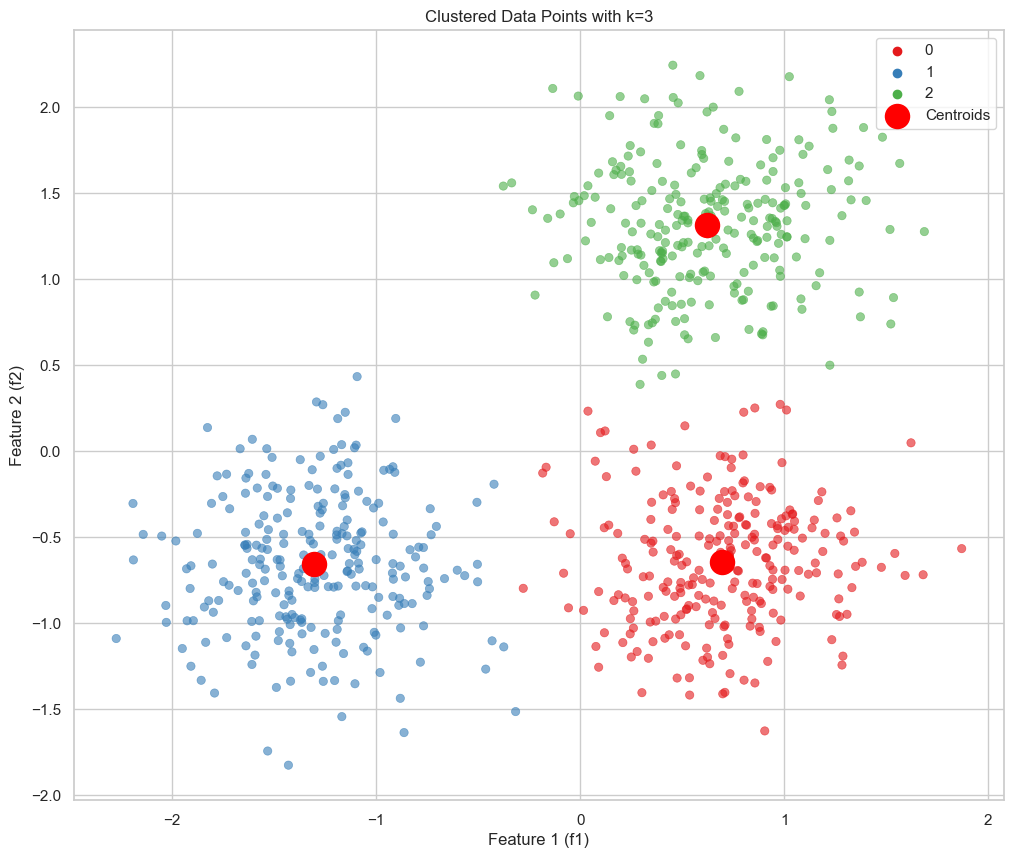

In [4]:
# Question 2: Rough Feature Ranges found visually

# Import necessary libraries
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Perform k-means clustering with k=3
kmeans_optimal = KMeans(n_clusters=3, random_state=42)
kmeans_optimal.fit(df)
cluster_labels_optimal = kmeans_optimal.labels_

# Add cluster labels to the original DataFrame
df['Cluster'] = cluster_labels_optimal

# Create a scatter plot for the clustered data points
plt.figure(figsize=(12, 10))
sns.scatterplot(x="f1", y="f2", hue="Cluster", data=df, palette="Set1", alpha=0.6, edgecolor=None)

# Plot the cluster centers
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=300, c='red', label='Centroids')

# Add titles and labels
plt.title('Clustered Data Points with k=3')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.legend()

# Show the plot
plt.show()


Species 1 has a feature 1 range of about -0.2 to 1.9, and a feature 2 range of -1.7 to 0.25.  
Species 2 has a feature 1 range of about -2.3 to -0.2, and a feature 2 range of -1.8 to 0.45.  
Species 3 has a feature 1 range of about -0.35 to 1.65, and a feature 2 range of 0.4 to 2.3.  

#### Question 3: Identify Outliers with K-Means

Anomalies or outliers in the context of clustering are typically data points that are far away from the centroids of their respective clusters. These points can be identified using the distance metric used in K-means clustering, which is often the Euclidean distance.  

Here's a step-by-step process to identifying anomalies using K-means:  

Calculate Cluster Centroids: K-means inherently provides the coordinates of cluster centroids.  

Compute Distances: For each data point, compute its distance to the centroid of the cluster to which it belongs. You can use the Euclidean distance formula for this.  

$$
\text{{Euclidean distance}} = \sqrt{{(x_1 - x_2)^2 + (y_1 - y_2)^2}}
$$
 
Set a Threshold: Determine a distance threshold beyond which a data point is considered an anomaly. This could be a set number based on domain knowledge or a percentile of distances for each cluster.  

Identify Anomalies: Data points whose distance to their cluster centroid is greater than the threshold are flagged as anomalies.  

Visual Inspection: Optionally, visualize the anomalies along with the clusters to verify if the points identified make sense as anomalies.  

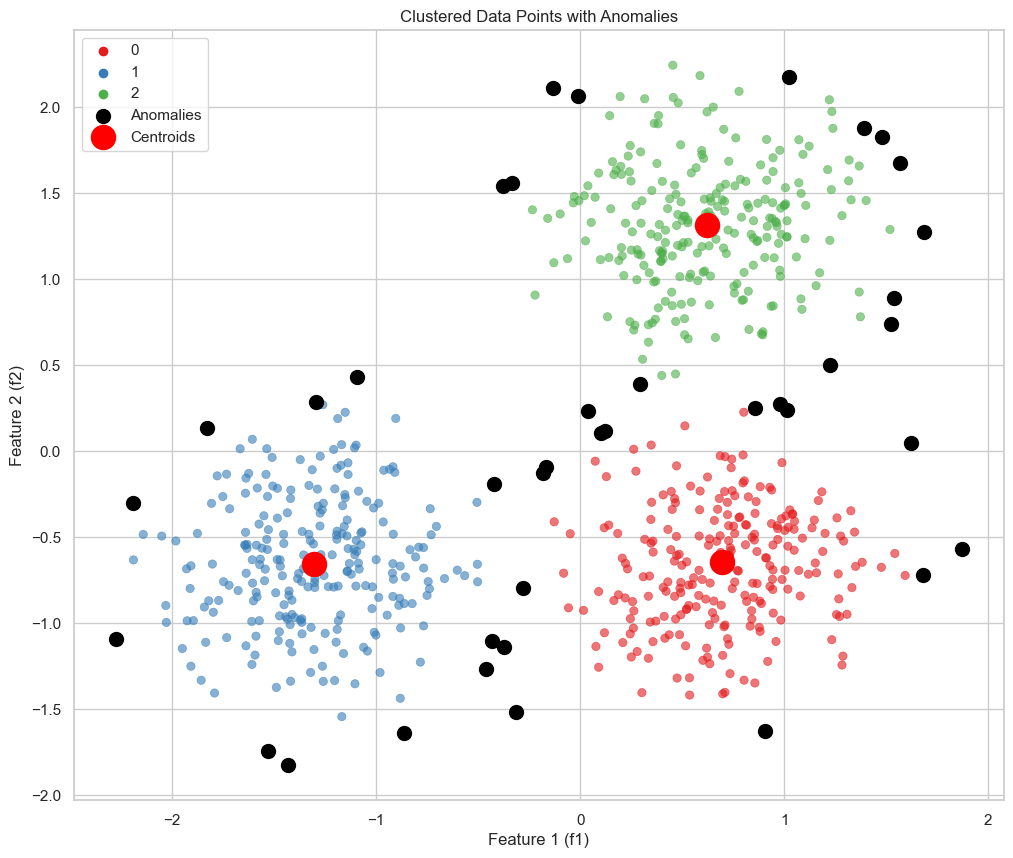

In [5]:
# Question 3: Identify Outliers with K-means

from scipy.spatial import distance

# Calculate the Euclidean distance for each point to its cluster's centroid
df['Distance_to_Centroid'] = df.apply(lambda row: distance.euclidean([row['f1'], row['f2']], kmeans_optimal.cluster_centers_[int(row['Cluster'])]), axis=1)

# Compute a threshold distance beyond which we consider a point an anomaly. We can use the 95th percentile as a threshold.
thresholds = df.groupby('Cluster')['Distance_to_Centroid'].quantile(0.95).reset_index()

# Find the anomalies (data points whose distance to their centroid is greater than the threshold)
anomalies = pd.DataFrame()

for i in range(len(thresholds)):
    anomalies_cluster = df[(df['Cluster'] == thresholds.loc[i, 'Cluster']) & (df['Distance_to_Centroid'] > thresholds.loc[i, 'Distance_to_Centroid'])]
    anomalies = pd.concat([anomalies, anomalies_cluster], axis=0)

# Visualize the anomalies along with the clusters
plt.figure(figsize=(12, 10))
sns.scatterplot(x="f1", y="f2", hue="Cluster", data=df, palette="Set1", alpha=0.6, edgecolor=None)
plt.scatter(anomalies['f1'], anomalies['f2'], s=100, c='black', label='Anomalies')
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=300, c='red', label='Centroids')
plt.title('Clustered Data Points with Anomalies')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.legend()
plt.show()


#### Question 4: Outlier Detection with DBSCAN

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a density-based clustering algorithm that can also identify outliers or anomalies. Unlike K-means, DBSCAN doesn't require the number of clusters to be specified a priori and can find arbitrarily shaped clusters. Points that don't belong to any cluster are considered anomalies or outliers.  

Here's a step-by-step process for using DBSCAN to find anomalies:  

Steps:  
Perform DBSCAN Clustering: Run the DBSCAN algorithm on the dataset.  

Identify Core and Non-core Points: DBSCAN identifies core points, border points, and noise points (anomalies). In scikit-learn's DBSCAN implementation, core and border points are assigned to clusters (with labels starting from 0), and noise points are given the label -1.  

Extract Anomalies: Points labeled as -1 are considered anomalies.  

Visual Inspection: Optionally, visualize the DBSCAN clusters and anomalies to verify if the points identified make sense as anomalies.  

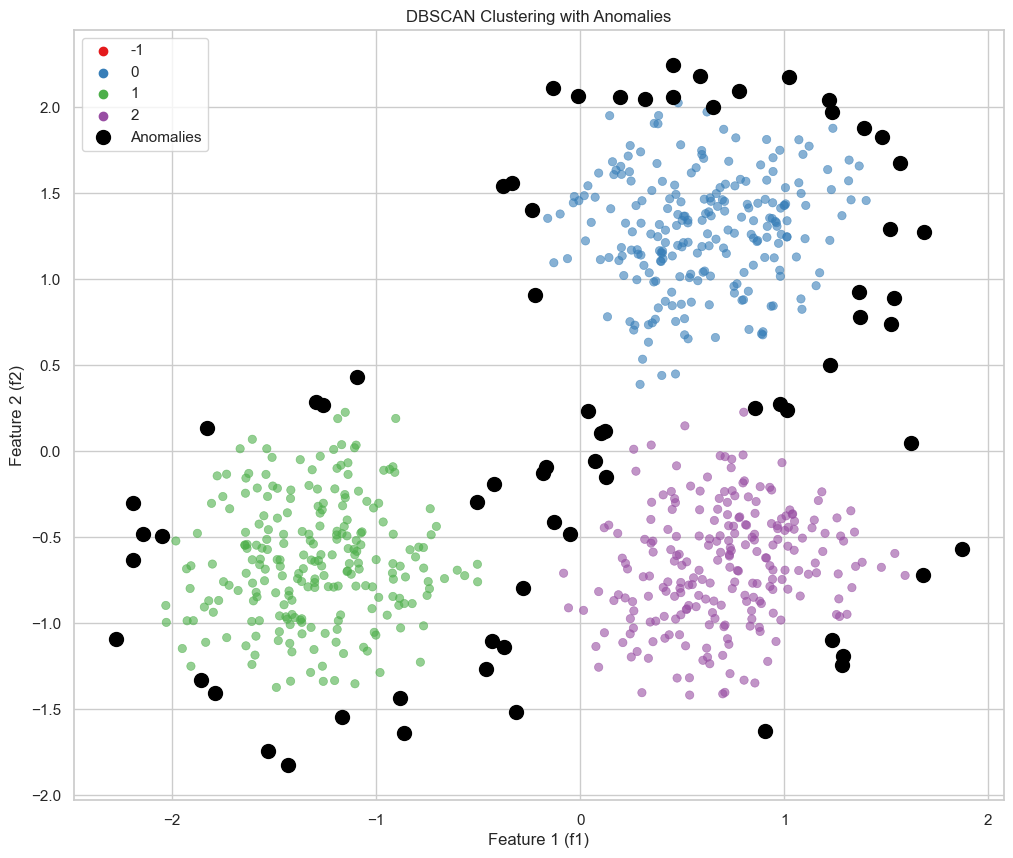

In [6]:
# Question 4: Anomaly Detection with DBSCAN

from sklearn.cluster import DBSCAN

# Initialize and fit the DBSCAN model
dbscan = DBSCAN(eps=0.25, min_samples=15) 
dbscan_labels = dbscan.fit_predict(df[['f1', 'f2']])

# Add DBSCAN labels to the original DataFrame
df['DBSCAN_Labels'] = dbscan_labels

# Identify the anomalies (noise points are labeled as -1 by DBSCAN)
anomalies_dbscan = df[df['DBSCAN_Labels'] == -1]

# Visualize the DBSCAN clusters and anomalies
plt.figure(figsize=(12, 10))
sns.scatterplot(x="f1", y="f2", hue="DBSCAN_Labels", data=df, palette="Set1", alpha=0.6, edgecolor=None)
plt.scatter(anomalies_dbscan['f1'], anomalies_dbscan['f2'], s=100, c='black', label='Anomalies')
plt.title('DBSCAN Clustering with Anomalies')
plt.xlabel('Feature 1 (f1)')
plt.ylabel('Feature 2 (f2)')
plt.legend()
plt.show()


Things look somewhat similar at an Epsilon value of 0.25 and 15 minimum points per cluster.  
There are more anomolies detected, and looking at the feature ranges I would trust DBSCAN more.  
There tends to be a nice spacing between the rings of outliers and the core of each cluster, visually.

#### Question 5: DBSCAN'd (Cleaned Data) Decision Tree

let's move on to building and visualizing a Decision Tree classifier using the cleaned dataset.  

Steps:  
Prepare the Cleaned Dataset: Remove the anomalies identified by DBSCAN to create the cleaned dataset.  

Split the Data: Partition the cleaned data into features (X) and labels (y) and further into training and testing sets.  

Train the Decision Tree Classifier: Use the training data to fit a Decision Tree model.  

Visualize the Decision Tree: Once the model is trained, visualize the decision tree to understand how it's making predictions.  

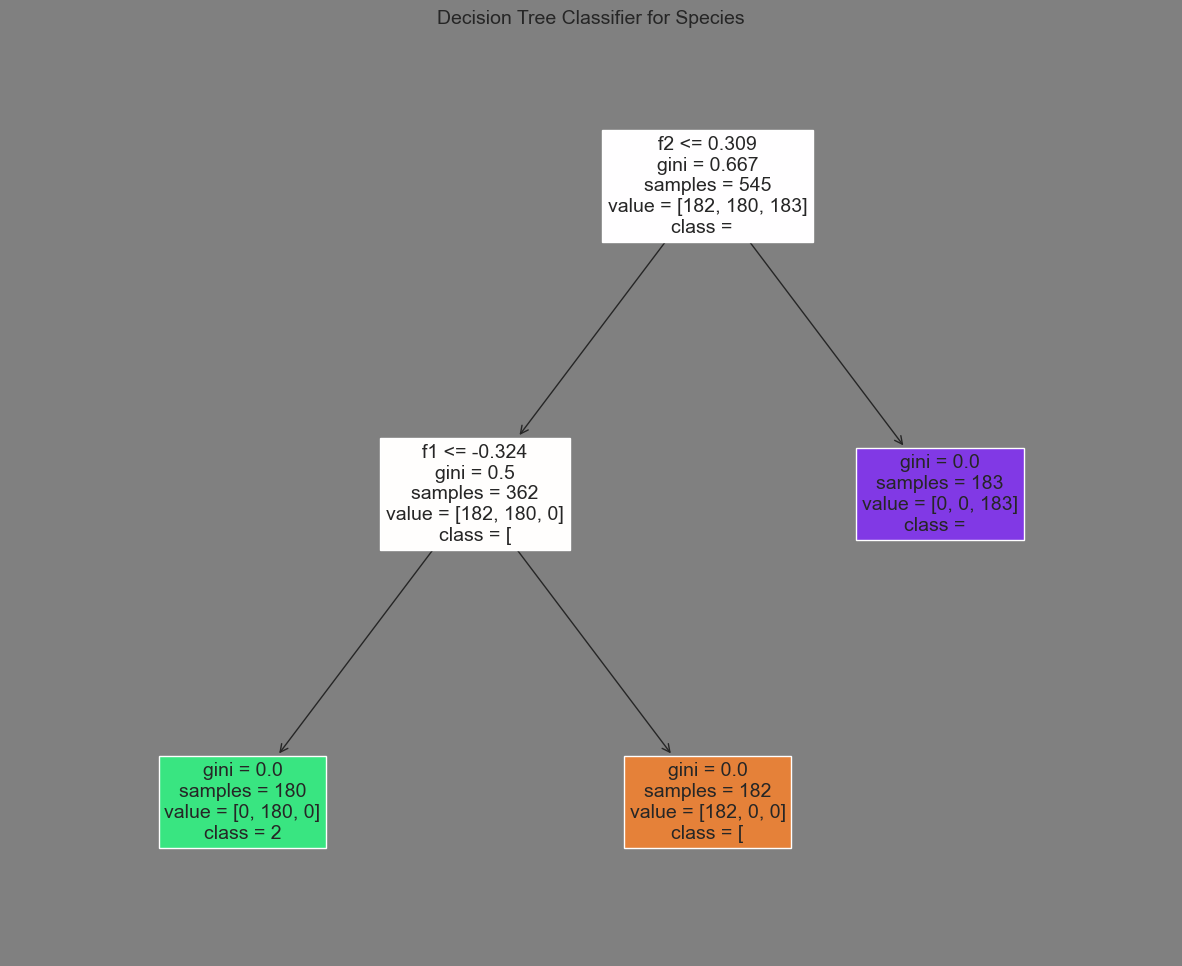

In [7]:
# Question 5: DBSCAN'd Data to Decision Tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# Prepare the cleaned dataset by removing anomalies (rows with DBSCAN_Labels = -1)
df_cleaned = df[df['DBSCAN_Labels'] != -1]

# Prepare the features and labels
X = df_cleaned[['f1', 'f2']]
y = df_cleaned['Cluster']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Visualize the Decision Tree
plt.figure(figsize=(15, 12), facecolor='grey') 
tree.plot_tree(clf, 
               feature_names=['f1', 'f2'], 
               class_names=str(y.unique()), 
               filled=True, 
               fontsize=14)  
plt.title('Decision Tree Classifier for Species', fontsize=14)
plt.show()


In [8]:
# Question 6: Demonstrating the Outlier Removal Improved the Decision Tree
# Let's compare to a Decision Tree of the Original

from sklearn.model_selection import cross_val_score
import numpy as np

# Original dataset
X_orig = df[['f1', 'f2']]
y_orig = df['Cluster']

# Cleaned dataset
X_clean = df_cleaned[['f1', 'f2']]
y_clean = df_cleaned['Cluster']

# Initialize and train classifiers
clf_orig = DecisionTreeClassifier(random_state=42)
clf_clean = DecisionTreeClassifier(random_state=42)

clf_orig.fit(X_orig, y_orig)
clf_clean.fit(X_clean, y_clean)

# Cross-validation
scores_orig = cross_val_score(clf_orig, X_orig, y_orig, cv=10)
scores_clean = cross_val_score(clf_clean, X_clean, y_clean, cv=10)

print("Original Data: Accuracy: %0.2f (+/- %0.2f)" % (scores_orig.mean(), scores_orig.std() * 2))
print("Cleaned Data: Accuracy: %0.2f (+/- %0.2f)" % (scores_clean.mean(), scores_clean.std() * 2))

# Model complexity
print("Original Data: Number of nodes: ", clf_orig.tree_.node_count)
print("Cleaned Data: Number of nodes: ", clf_clean.tree_.node_count)


Original Data: Accuracy: 1.00 (+/- 0.01)
Cleaned Data: Accuracy: 1.00 (+/- 0.00)
Original Data: Number of nodes:  7
Cleaned Data: Number of nodes:  5


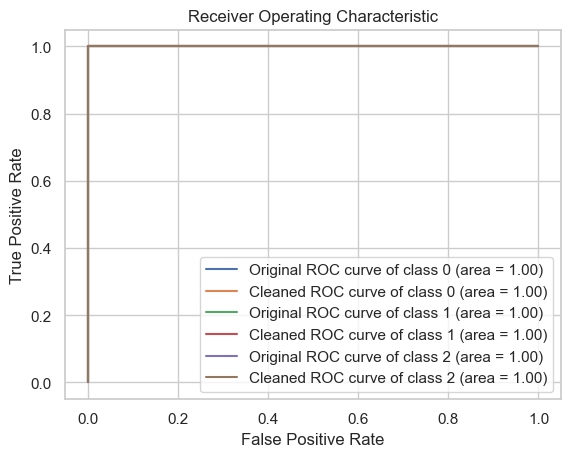

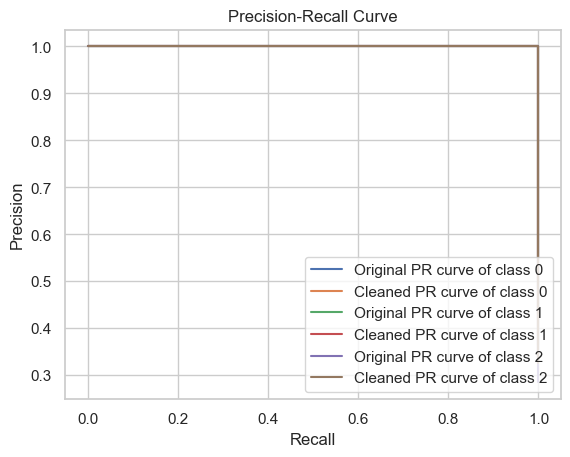

In [9]:
# Question 6: ROC and Precision-Recall Curve of the Original versus Cleaned Data Set Decision Trees

from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Initialize and train classifiers
clf_orig = DecisionTreeClassifier(random_state=42)
clf_clean = DecisionTreeClassifier(random_state=42)

clf_orig.fit(X_train, y_train)
clf_clean.fit(X_clean, y_clean)

# Predict probabilities
y_score_orig = clf_orig.predict_proba(X_test)
y_score_clean = clf_clean.predict_proba(X_clean)

# Binarize the labels for multi-class ROC and PR curves
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_clean_bin = label_binarize(y_clean, classes=[0, 1, 2])

# ROC Curve
plt.figure()
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score_orig[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Original ROC curve of class {i} (area = {roc_auc:0.2f})')

    fpr, tpr, _ = roc_curve(y_clean_bin[:, i], y_score_clean[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Cleaned ROC curve of class {i} (area = {roc_auc:0.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
plt.figure()
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score_orig[:, i])
    plt.plot(recall, precision, label=f'Original PR curve of class {i}')

    precision, recall, _ = precision_recall_curve(y_clean_bin[:, i], y_score_clean[:, i])
    plt.plot(recall, precision, label=f'Cleaned PR curve of class {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()


We can see that the outlier removal reduced the number of nodes, but as of now both pipelines result in overfitting.  
They are both low depth, high split number and high minimum samples per leaf, so I'm not sure what I'm doing wrong.  The data set may be just that simple and clear. Performance may deteriorate in cross-validation. I would appreciate feedback here because overfitting is something I'm still wrapping my head around.

But also to show the benefit of cleaning, we can do that cross-validation, and then we can plot learning curves for both models (trained on original and cleaned data). A model trained on cleaned data should converge faster and plateau at a higher performance level, indicating better generalization.

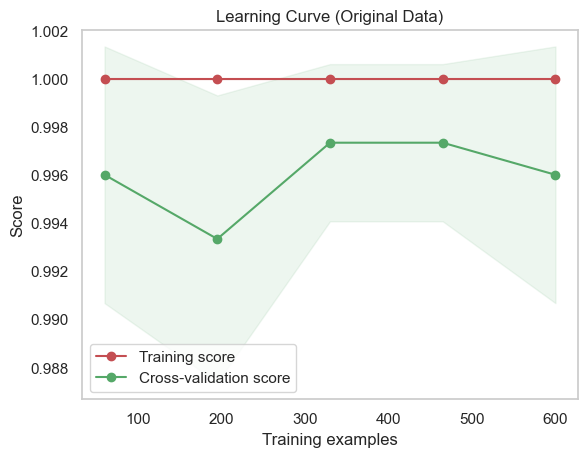

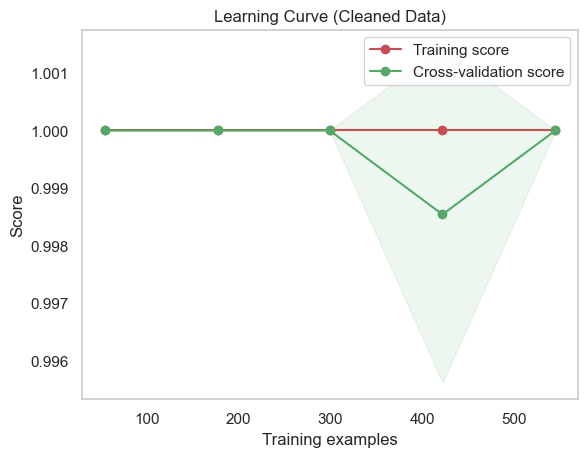

In [10]:
# Plotting the Learning Curve

from sklearn.model_selection import learning_curve

# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt

# Plot learning curve for original data
plot_learning_curve(DecisionTreeClassifier(random_state=42), 'Learning Curve (Original Data)', X_orig, y_orig, cv=5)

# Plot learning curve for cleaned data
plot_learning_curve(DecisionTreeClassifier(random_state=42), 'Learning Curve (Cleaned Data)', X_clean, y_clean, cv=5)

plt.show()


The Decision Tree with the Cleaned Data does in fact converge faster and plateau at a higher performance level, indicating better generalization.